In [1]:
!pip install opencv-python-headless pytesseract psycopg2-binary
!apt-get update
!apt-get install -y libgl1-mesa-glx tesseract-ocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 28.0 MB/s eta 0:00:00
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3,891 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe a

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Binary image shape: (537, 832)


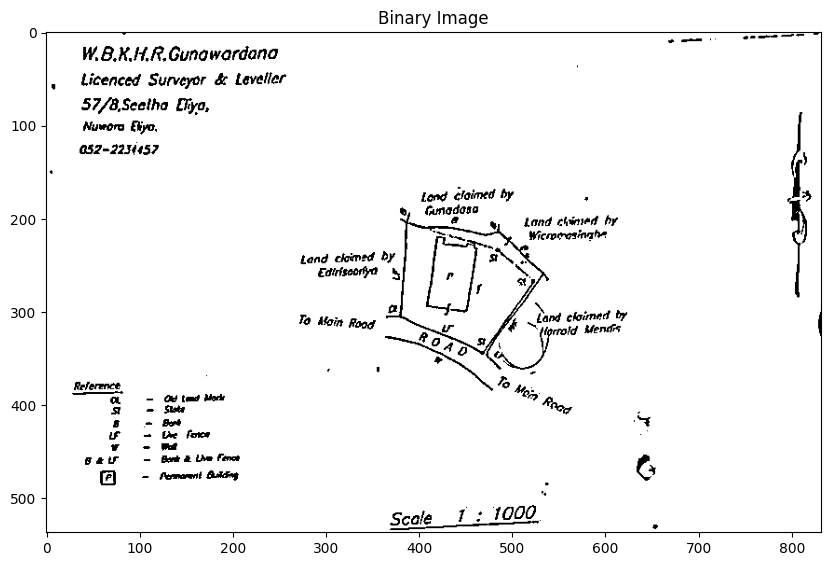

Filtered texts (confidence > 50): ['Gunawardana', ',', ' ticenced', 'Surveyor', '&', '57/8,Seetha', 'fiya,', '052=', '2254457', 'Lond', 'claimed', 'by', 'e,', 'damadeso', '¢', 'chained', 'by', 'tand', 'dy', 'f', 'a', '\\', 'Ja', 'Rood', '|', '>', 'Reference', '—', 'tend', 'Mork', ';', 'Bet', '—', 'tre', 'Bair', '—', 'the', 'fence', '[7]', '—', '.', 'Cs', '1000.']
Confidences: [62, 78, 53, 93, 91, 82, 71, 68, 83, 90, 85, 96, 55, 58, 55, 53, 82, 90, 77, 60, 53, 56, 56, 66, 90, 74, 95, 89, 60, 64, 63, 68, 67, 82, 54, 64, 75, 54, 63, 51, 58, 82, 82]
Road-related text detected: afoin
Number of horizontal lines detected: 0
No road detected


In [18]:
import cv2
import pytesseract
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Load the image
image_path = '/content/drive/MyDrive/Colab Notebooks/siteImage.png'
image = cv2.imread(image_path)

# Check if the image loaded
if image is None:
    print("Error: Could not load image. Check the file path.")
else:
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Denoise with lighter settings
    denoised = cv2.fastNlMeansDenoising(gray, None, 5, 7, 15)

    # Apply adaptive thresholding with adjusted parameters
    binary = cv2.adaptiveThreshold(denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 5)

    # Resize the image (scale factor = 4)
    scale_factor = 4
    binary_resized = cv2.resize(binary, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)

    # Debug: Show binary image
    print("Binary image shape:", binary.shape)
    plt.figure(figsize=(10, 10))
    plt.imshow(binary, cmap='gray')
    plt.title('Binary Image')
    plt.show()

    # Run Tesseract with custom settings
    text_data = pytesseract.image_to_data(binary_resized, output_type=pytesseract.Output.DICT, lang='eng', config='--psm 6 --oem 3')

    # Adjust text coordinates back to original scale
    for key in ['left', 'top', 'width', 'height']:
        text_data[key] = [int(coord / scale_factor) for coord in text_data[key]]

    # Filter detected text by confidence (>50 for debugging)
    detected_texts = [text for i, text in enumerate(text_data['text']) if text.strip() and text_data['conf'][i] > 50]
    confidences = [text_data['conf'][i] for i, text in enumerate(text_data['text']) if text.strip() and text_data['conf'][i] > 50]

    # Print filtered results
    print("Filtered texts (confidence > 50):", detected_texts)
    print("Confidences:", confidences)

    # Check for road-related text with relaxed matching
    road_keywords = ['road', 'street', 'main road', 'to main road', 'moin roo', 'moin rood', 'main rood', 'to main', 'load', 'rood', 'fo', 'moin']
    detected_texts_lower = [text.lower().strip().replace(' ', '').replace('.', '') for text in text_data['text'] if text.strip()]
    road_detected = False
    for i, text in enumerate(detected_texts_lower):
        if text_data['conf'][i] > 50 and any(keyword.lower().replace(' ', '') in text for keyword in road_keywords):
            road_detected = True
            print("Road-related text detected:", text)

    # Detect lines (focus on horizontal lines)
    edges = cv2.Canny(denoised, 30, 100)  # Use denoised image for edges
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=250, maxLineGap=20)
    horizontal_lines = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # More stringent check for horizontal lines (slope closer to 0)
            if abs(y2 - y1) < 0.03 * abs(x2 - x1):
                horizontal_lines.append(line)
    print("Number of horizontal lines detected:", len(horizontal_lines))

    # Debug: Show detected horizontal lines
    if horizontal_lines:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        for line in horizontal_lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
        plt.figure(figsize=(10, 10))
        plt.imshow(image_rgb)
        plt.title('Horizontal Lines Detected')
        plt.show()

    # Create mask with horizontal lines
    mask = np.zeros_like(gray)
    if horizontal_lines:
        for line in horizontal_lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(mask, (x1, y1), (x2, y2), 255, 200)  # Thickness 200 pixels

    # Function to detect road features
    def detect_features(mask, text_data, road_keywords):
        features = []
        for i in range(len(text_data['text'])):
            text = text_data['text'][i].lower().strip().replace(' ', '').replace('.', '')
            if text_data['conf'][i] > 50 and any(keyword.lower().replace(' ', '') in text for keyword in road_keywords):
                x_center = text_data['left'][i] + text_data['width'][i] / 2
                y_center = text_data['top'][i] + text_data['height'][i] / 2
                y_center = min(max(int(y_center), 0), mask.shape[0] - 1)
                x_center = min(max(int(x_center), 0), mask.shape[1] - 1)
                if mask[y_center, x_center] > 0:
                    features.append('road')
        return list(set(features))

    # Detect features
    detected_features = detect_features(mask, text_data, road_keywords)

    # Final output
    if 'road' in detected_features:
        print("Road recognized")
    else:
        print("No road detected")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Binary image shape: (537, 832)


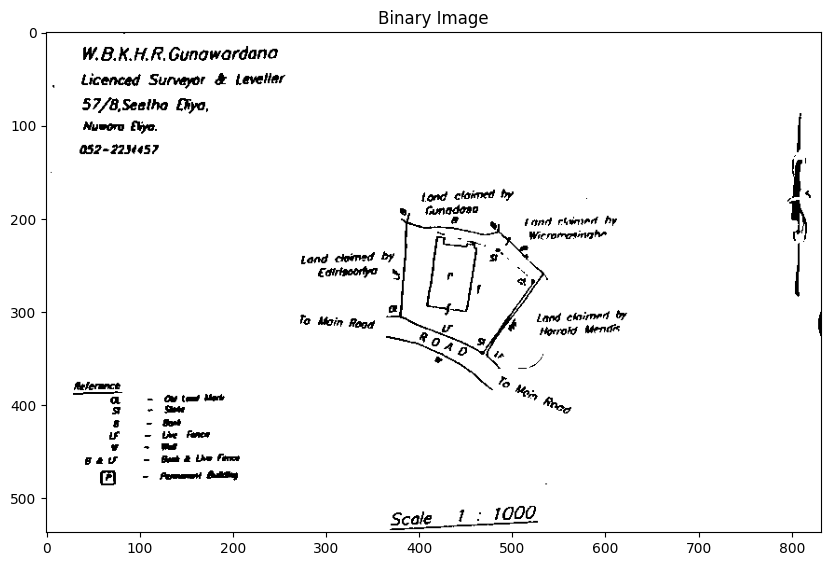

Filtered texts (confidence > 50): ['Gunawardana', 'Surveyor', '&', '57/8,Seatha', 'Ekyo,', 'Nuwora', '|', '|', 'fond', 'hy', 'I.', 'funadosa', '%', 'fand', 'pp', '|', 'by', 'ot', 'fa', 'Moin', '*', 'Land', 'by', '|', 'My.', '3', '~', 'Siete', '8', '-', 'Sant', 'if', '—', ',', '7', 'Gear', '&', 'Lae', 'force', '|', 'Scale', '1000']
Confidences: [75, 90, 90, 81, 67, 74, 93, 78, 88, 78, 59, 51, 58, 55, 60, 91, 95, 56, 74, 87, 53, 82, 90, 90, 59, 56, 69, 74, 92, 82, 63, 62, 60, 54, 66, 73, 83, 67, 67, 53, 68, 94]
Road-related text detected: fond
Number of horizontal lines detected: 19


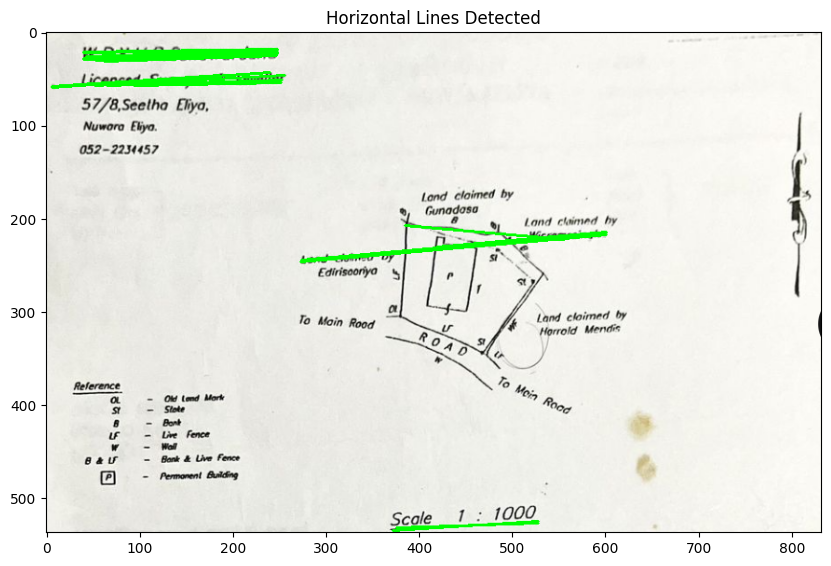

Road recognized


In [20]:
import cv2
import pytesseract
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt

# Optional: Install fuzzywuzzy for fuzzy matching
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz

# Define the is_road_related function at the top
def is_road_related(text, keywords, threshold=70):
    text = text.lower().strip().replace(' ', '').replace('.', '')
    for keyword in keywords:
        keyword = keyword.lower().replace(' ', '').replace('.', '')
        if fuzz.ratio(text, keyword) > threshold or keyword in text:
            return True
    return False

# Mount Google Drive
drive.mount('/content/drive')

# Load the image
image_path = '/content/drive/MyDrive/Colab Notebooks/siteImage.png'
image = cv2.imread(image_path)

# Check if the image loaded
if image is None:
    print("Error: Could not load image. Check the file path.")
else:
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Denoise with lighter settings
    denoised = cv2.fastNlMeansDenoising(gray, None, 3, 7, 15)

    # Apply Otsu’s thresholding
    _, binary = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Resize the image (scale factor = 6)
    scale_factor = 6
    binary_resized = cv2.resize(binary, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)

    # Debug: Show binary image
    print("Binary image shape:", binary.shape)
    plt.figure(figsize=(10, 10))
    plt.imshow(binary, cmap='gray')
    plt.title('Binary Image')
    plt.show()

    # Run Tesseract with custom settings
    text_data = pytesseract.image_to_data(binary_resized, output_type=pytesseract.Output.DICT, lang='eng', config='--psm 6 --oem 3')

    # Adjust text coordinates back to original scale
    for key in ['left', 'top', 'width', 'height']:
        text_data[key] = [int(coord / scale_factor) for coord in text_data[key]]

    # Filter detected text by confidence (>50 for debugging)
    detected_texts = [text for i, text in enumerate(text_data['text']) if text.strip() and text_data['conf'][i] > 50]
    confidences = [text_data['conf'][i] for i, text in enumerate(text_data['text']) if text.strip() and text_data['conf'][i] > 50]

    # Print filtered results
    print("Filtered texts (confidence > 50):", detected_texts)
    print("Confidences:", confidences)

    # Check for road-related text with relaxed matching
    road_keywords = ['road', 'street', 'main road', 'to main road', 'moin roo', 'moin rood', 'main rood', 'to main', 'load', 'rood', 'fo', 'moin', 'ja', 'jarood', 'jaro']
    detected_texts_lower = [text.lower().strip().replace(' ', '').replace('.', '') for text in text_data['text'] if text.strip()]
    road_detected = False
    for i, text in enumerate(detected_texts_lower):
        if text_data['conf'][i] > 50 and (any(keyword.lower().replace(' ', '') in text for keyword in road_keywords) or is_road_related(text, road_keywords, 70)):
            road_detected = True
            print("Road-related text detected:", text)

    # Detect lines (focus on horizontal lines)
    edges = cv2.Canny(denoised, 20, 80)  # Adjusted Canny thresholds
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=150, maxLineGap=30)
    horizontal_lines = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Relaxed check for horizontal lines (slope closer to 0)
            if abs(y2 - y1) < 0.1 * abs(x2 - x1):
                horizontal_lines.append(line)
    print("Number of horizontal lines detected:", len(horizontal_lines))

    # Debug: Show detected horizontal lines
    if horizontal_lines:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        for line in horizontal_lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
        plt.figure(figsize=(10, 10))
        plt.imshow(image_rgb)
        plt.title('Horizontal Lines Detected')
        plt.show()

    # Create mask with horizontal lines
    mask = np.zeros_like(gray)
    if horizontal_lines:
        for line in horizontal_lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(mask, (x1, y1), (x2, y2), 255, 300)  # Increased thickness to 300 pixels

    # Function to detect road features
    def detect_features(mask, text_data, road_keywords):
        features = []
        for i in range(len(text_data['text'])):
            text = text_data['text'][i].lower().strip().replace(' ', '').replace('.', '')
            if text_data['conf'][i] > 50 and (any(keyword.lower().replace(' ', '') in text for keyword in road_keywords) or is_road_related(text, road_keywords, 70)):
                x_center = text_data['left'][i] + text_data['width'][i] / 2
                y_center = text_data['top'][i] + text_data['height'][i] / 2
                y_center = min(max(int(y_center), 0), mask.shape[0] - 1)
                x_center = min(max(int(x_center), 0), mask.shape[1] - 1)
                if mask[y_center, x_center] > 0:
                    features.append('road')
        return list(set(features))

    # Detect features
    detected_features = detect_features(mask, text_data, road_keywords)

    # Final output
    if 'road' in detected_features:
        print("Road recognized")
    else:
        print("No road detected")